## Importing libraries

For any issues running these modules, use python -m pip install -r requirements.txt

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import sklearn
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Load data, add a new field

In [11]:
apple = yf.Ticker("AAPL")
hist = apple.history(start="2000-01-03", end="2020-09-30", actions=False) # 2000-01-03 is Monday.

## Plot Data

Visualize the data that we have extracted to better understand trends to expect and routes to go for changing parameters.

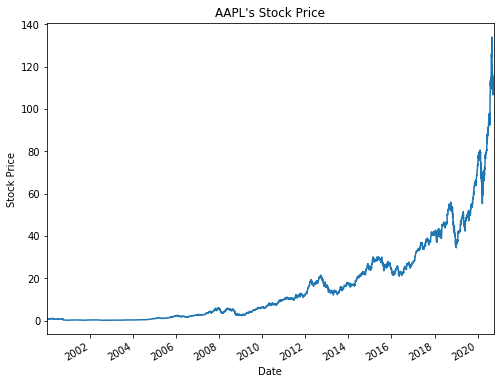

In [3]:
# Quarterly history of Tablular data:
def cleanHist(hist):
    clean_hist = hist.copy()
    for index, row in hist.iterrows():
        if np.isnan(row['Open']):
            clean_hist = clean_hist.drop(index)
    return clean_hist

# Converts timestamp object to nice-looking date
def convertTimeStamp(timestamp):
    return str(timestamp)[5:7] + "/" + str(timestamp)[:4]

def getDates(index):
    return [convertTimeStamp(timestamp) for timestamp in index]

quarterly_hist = apple.history(start="2000-01-01", end="2020-09-30", interval="3mo", actions=False)
quarterly_percent = (quarterly_hist["Close"]-quarterly_hist["Open"])/quarterly_hist["Open"]*100
quarterly_hist["%Increase"] = quarterly_percent
quarterly_hist = cleanHist(quarterly_hist)

# Table of quarterly data
fig = go.Figure(data=[go.Table(
    header=dict(values=['Date'] + list(quarterly_hist.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[getDates(quarterly_hist.index), round(quarterly_hist['Open'], 4),
                       round(quarterly_hist['High'], 4), round(quarterly_hist['Low'], 4),
                       round(quarterly_hist['Close'], 4), quarterly_hist['Volume'],
                       round(quarterly_hist['%Increase'], 4)],
               fill_color='lavender',
               align='center'))
])

fig.show()

# AAPL Stock Price
fig = plt.figure(figsize=(8, 14))
ax1 = fig.add_subplot(211)
ax1.set_title('AAPL\'s Stock Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price')
hist["Close"].plot()
plt.show()

# AAPL Bar Chart
bar_chart = {
    'x': hist.index,
    'open': hist.Open,
    'close': hist.Close,
    'high': hist.High,
    'low': hist.Low,
    'type': 'candlestick',
    'name': 'AAPL',
    'showlegend': True
}

pio.show(bar_chart)


# Stacked LSTM Model

Data preparation

In [70]:
hist=hist.reset_index()
hist=hist.loc[:,'Close']
hist=pd.DataFrame(hist)

Data Transformation

In [71]:
training_window=10
forward_window=1
x=[]
y=[]
for i in range(0,hist.shape[0]-forward_window-training_window+1,forward_window):
    x.append(np.array(hist.iloc[i:(i+training_window),:]).reshape(training_window,1))
    y.append(np.array(hist.iloc[(i+training_window):(i+training_window+forward_window),:]))
x_train=np.array(x[:4000])
y_train=np.array(y[:4000])
x_test=np.array(x[4000:])
y_test=np.array(y[4000:])

Initialize Model

In [178]:
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout,Activation
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
import tensorflow as tf

model=Sequential()
model.add(LSTM(100,activation='relu',return_sequences=True,input_shape=(training_window,1),
               kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=2/np.sqrt(500), seed=None)))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
))

Model Tuning

In [144]:
results=[]
for i in [20,50,100,150,200]:
    test_model=Sequential()
    test_model.add(LSTM(i,activation='relu',return_sequences=True,input_shape=(training_window,1)))
    test_model.add(LSTM(int(i/2),activation='relu'))
    test_model.add(Dense(1,activation='linear'))
    test_model.compile(loss='mean_squared_error',optimizer='adam')
    testLSTM=test_model.fit(x_train,y_train,batch_size=64,epochs=100,validation_split=0.2,verbose=0,use_multiprocessing=True)
    results.append([testLSTM.history['val_loss'],testLSTM.history['loss']])
results=np.array(results)

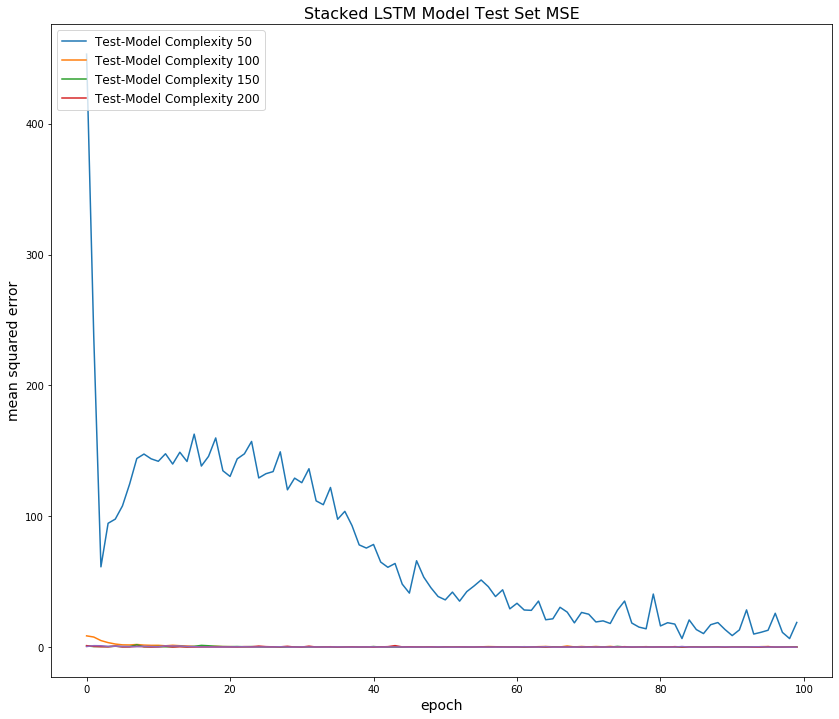

In [158]:
#Tune Model complexity
plt.figure(figsize=(14,12))
plt.plot(results[0][0])
plt.plot(results[1][0])
plt.plot(results[2][0])
plt.plot(results[3][0])
plt.plot(results[4][0])
plt.title('Stacked LSTM Model Test Set MSE',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['Test-Model Complexity 50',
            'Test-Model Complexity 100','Test-Model Complexity 150',
           'Test-Model Complexity 200'], loc='upper left', fontsize='large')
plt.show()

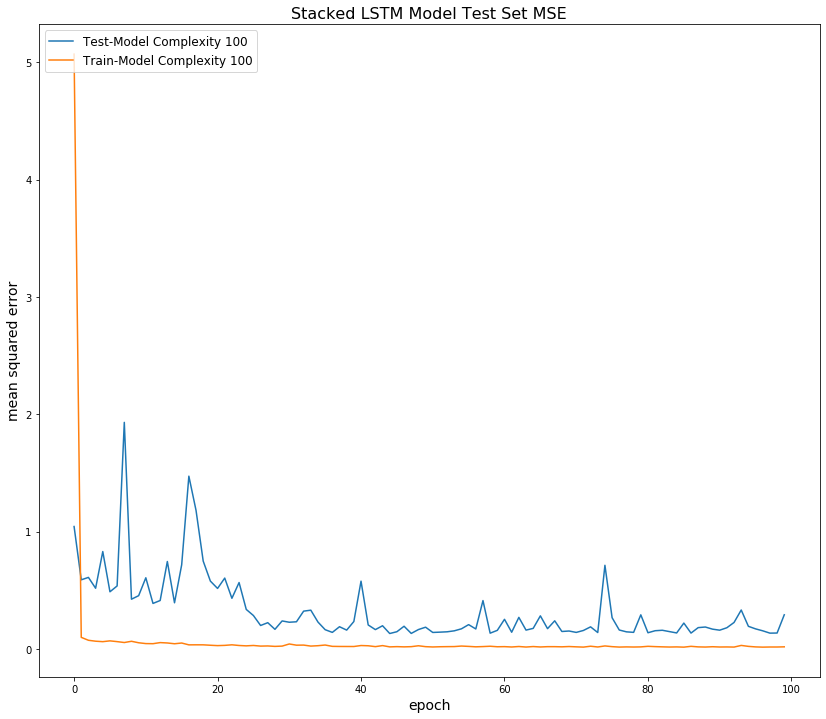

In [162]:
#Tune epochs
plt.figure(figsize=(14,12))
plt.plot(results[2][0])
plt.plot(results[2][1])
plt.title('Stacked LSTM Model Test Set MSE',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['Test-Model Complexity 100','Train-Model Complexity 100'], loc='upper left', fontsize='large')
plt.show()

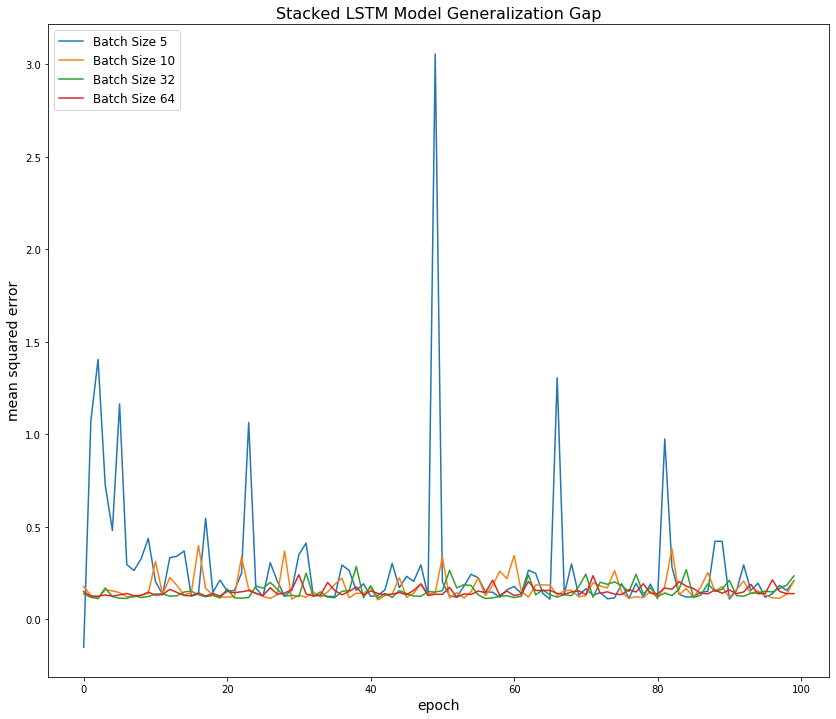

In [49]:
#Tune batch_size
results=[]
for i in [5,10,32,64]:
    stackedLSTM=model.fit(x_train,y_train,batch_size=i,epochs=100,validation_split=0.2,verbose=0,use_multiprocessing=True)
    results.append(np.array(stackedLSTM.history['val_loss'])-np.array(stackedLSTM.history['loss']))
    
plt.figure(figsize=(14,12))
plt.plot(results[0])
plt.plot(results[1])
plt.plot(results[2])
plt.plot(results[3])
#plt.plot(np.array(stackedLSTM.history['val_loss'])-np.array(stackedLSTM.history['loss']))
plt.title('Stacked LSTM Model Generalization Gap',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['Batch Size 5', 'Batch Size 10','Batch Size 32','Batch Size 64'], loc='upper left', fontsize='large')
plt.show()

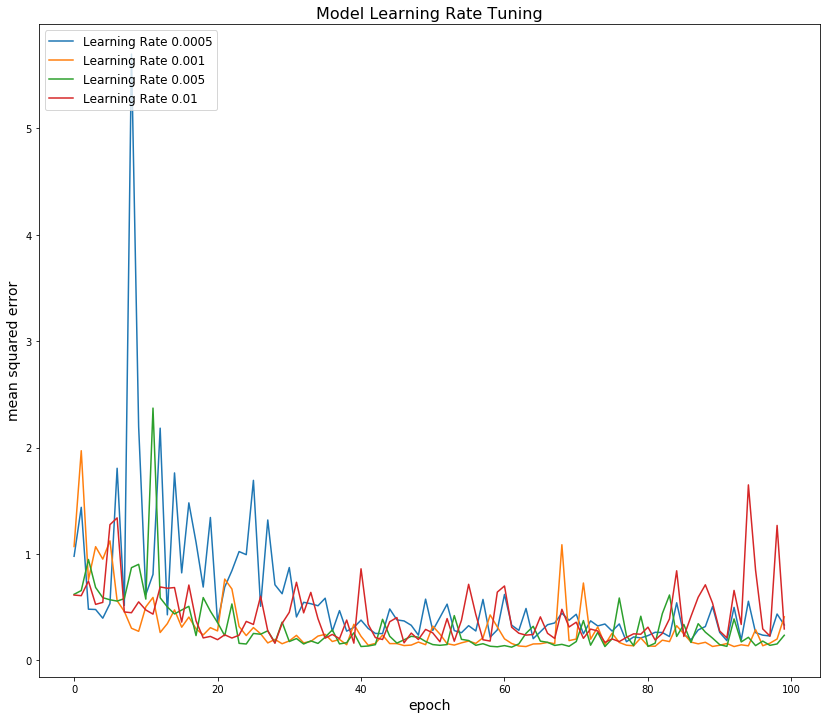

In [170]:
#Tune learning rate
results=[]
for i in [0.0001,0.0005,0.001,0.005,0.01]:
    testModel=Sequential()
    testModel.add(LSTM(100,activation='relu',return_sequences=True,input_shape=(training_window,1)))
    testModel.add(LSTM(50,activation='relu'))
    testModel.add(Dense(1,activation='linear'))
    testModel.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(
        learning_rate=i,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam"
    ))
    history=testModel.fit(x_train,y_train,batch_size=64,epochs=100,validation_split=0.2,verbose=0,use_multiprocessing=True)
    results.append(history.history['val_loss'])

plt.figure(figsize=(14,12))
for i in range(1,len(results)):
    plt.plot(np.arange(100),results[i])
plt.title('Model Learning Rate Tuning',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['Learning Rate 0.0005',
            'Learning Rate 0.001','Learning Rate 0.005','Learning Rate 0.01'], loc='upper left', fontsize='large')
plt.show()

In [176]:
#Tune for kernel initialization
model1=Sequential()
model1.add(LSTM(100,activation='relu',return_sequences=True,input_shape=(training_window,1),
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=2/np.sqrt(500), seed=None)))
model1.add(LSTM(50,activation='relu'))
model1.add(Dense(1,activation='linear'))
model1.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
))
test1=model1.fit(x_train,y_train,batch_size=64,epochs=100,validation_split=0.2,verbose=0)

model2=Sequential()
model2.add(LSTM(100,activation='relu',return_sequences=True,input_shape=(training_window,1)))
model2.add(LSTM(50,activation='relu'))
model2.add(Dense(1,activation='linear'))
model2.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
))
test2=model2.fit(x_train,y_train,batch_size=64,epochs=100,validation_split=0.2,verbose=0)

model3=Sequential()
model3.add(LSTM(100,activation='relu',return_sequences=True,input_shape=(training_window,1),
                kernel_initializer=tf.keras.initializers.GlorotNormal()))
model3.add(LSTM(50,activation='relu'))
model3.add(Dense(1,activation='linear'))
model3.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
))
test3=model3.fit(x_train,y_train,batch_size=64,epochs=100,validation_split=0.2,verbose=0)

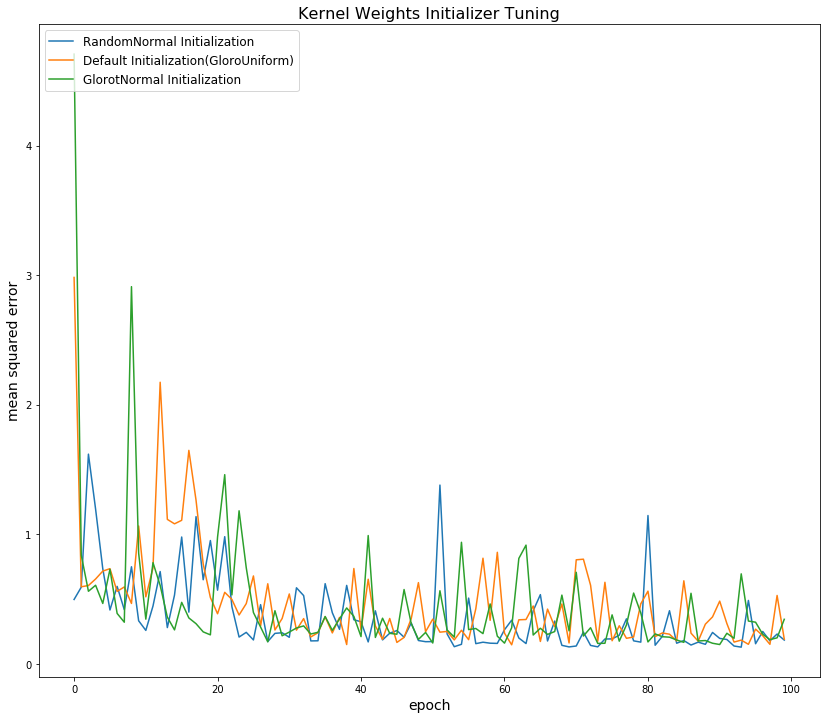

In [177]:
plt.figure(figsize=(14,12))
plt.plot(test1.history['val_loss'])
plt.plot(test2.history['val_loss'])
plt.plot(test3.history['val_loss'])
plt.title('Kernel Weights Initializer Tuning',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['RandomNormal Initialization',
            'Default Initialization(GloroUniform)','GlorotNormal Initialization'], loc='upper left', fontsize='large')
plt.show()

Model Training

In [179]:
model.fit(x_train,y_train,batch_size=64,epochs=100,validation_split=0.2,callbacks=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=30,
    restore_best_weights=True,
))
#model.fit(x_train,y_train,batch_size=5,epochs=3,validation_split=0.2,verbose=0)

Epoch 1/100
50/50 [==============================] - 1s 11ms/step - loss: 8.0077 - val_loss: 3.2798
Epoch 2/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0846 - val_loss: 1.9290
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0753 - val_loss: 2.0286
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0812 - val_loss: 0.6007
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0753 - val_loss: 0.5110
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0640 - val_loss: 0.5832
Epoch 7/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0673 - val_loss: 1.6032
Epoch 8/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0829 - val_loss: 1.2424
Epoch 9/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0835 - val_loss: 1.7910
Epoch 10/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0595 - val_loss: 0.4489
Epoch 11

Epoch 83/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0194 - val_loss: 0.1498
Epoch 84/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0228 - val_loss: 0.2076
Epoch 85/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0170 - val_loss: 0.1636
Epoch 86/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0183 - val_loss: 0.2068
Epoch 87/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0226 - val_loss: 0.1950
Epoch 88/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0148 - val_loss: 0.1253
Epoch 89/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0151 - val_loss: 0.1453
Epoch 90/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0193 - val_loss: 0.1318
Epoch 91/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0210 - val_loss: 0.2090
Epoch 92/100
50/50 [==============================] - 0s 7ms/step - loss: 0.0250 - val_loss: 0.1738


Model Testing

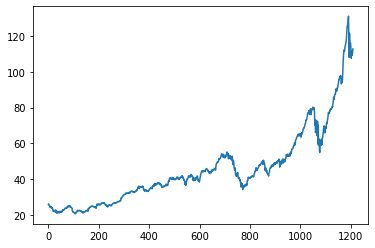

In [180]:
predicted=model.predict(x_test)

plt.plot(predicted.flatten())

In [181]:
from sklearn.metrics import mean_squared_error
print('MSE of the Single Variate Stacked LSTM is: ',mean_squared_error(predicted.flatten(),y_test.flatten()))

MSE of the Single Variate Stacked LSTM is:  2.1254162782231543


In [183]:
model.save('SingleVariate_LSTM_MSE2.12')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: SingleVariate_LSTM_MSE2.12/assets


In [91]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_63 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


# CNN-LSTM

Data Pre-processing

In [12]:
hist=hist.reset_index()
hist=hist.loc[:,'Close']
hist=pd.DataFrame(hist)

Data Transformation

In [13]:
training_window=20
forward_window=1
x=[]
y=[]
counter=0
for i in range(0,hist.shape[0]-forward_window-training_window+1,forward_window):
    x.append(np.array(hist.iloc[i:(i+training_window),0]))
    y.append(np.array(hist.iloc[(i+training_window):(i+training_window+forward_window),0]))

x_train=np.array(x[:4000])
y_train=np.array(y[:4000])
x_test=np.array(x[4000:])
y_test=np.array(y[4000:])
x_train=x_train.reshape((x_train.shape[0],2,10,1))
x_test=x_test.reshape((x_test.shape[0],2,10,1))

Initialize Model

In [68]:
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout,Activation
import tensorflow as tf
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal())
                          , input_shape=(None, 10, 1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.005,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam"
    ), loss='mse')

Model Tuning

In [35]:
#Tune model complexity
results=[]
for i in [50,100,150,200]:
    testModel = Sequential()
    testModel.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation='relu'), input_shape=(None, 10, 1)))
    testModel.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    testModel.add(TimeDistributed(Flatten()))
    testModel.add(LSTM(i, activation='relu'))
    testModel.add(Dense(1,activation='linear'))
    testModel.compile(optimizer='adam', loss='mse')
    history=testModel.fit(x_train,y_train,epochs=300,validation_split=0.2,verbose=0,use_multiprocessing=True)
    results.append(history.history['val_loss'])

plt.figure(figsize=(14,12))
for i in range(1,len(results)):
    plt.plot(np.arange(300),results[i])
plt.title('Model Complexity Tuning',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['Complexity-50','Complexity-100','Complexity-150','Complexity-200'], loc='upper left', fontsize='large')
plt.ylim(0,1.5)
plt.show()

_NotOkStatusException: InvalidArgumentError: Error while reading CompositeTensor._type_spec.

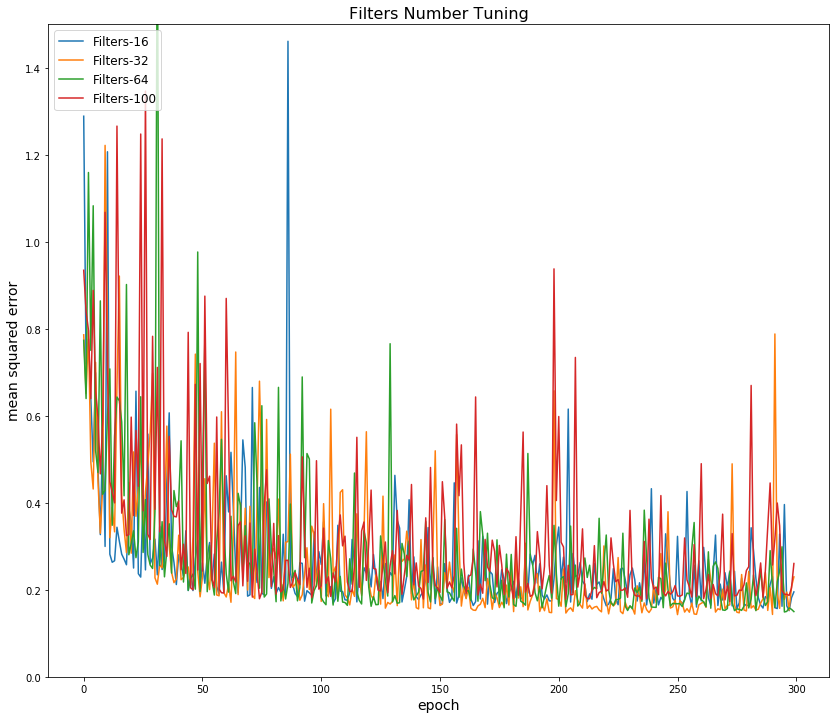

In [195]:
#Tune filters size
results=[]
for i in [16,32,64,100]:
    testModel = Sequential()
    testModel.add(TimeDistributed(Conv1D(filters=i, kernel_size=5, activation='relu'), input_shape=(None, 10, 1)))
    testModel.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    testModel.add(TimeDistributed(Flatten()))
    testModel.add(LSTM(100, activation='relu'))
    testModel.add(Dense(1,activation='linear'))
    testModel.compile(optimizer='adam', loss='mse')
    history=testModel.fit(x_train,y_train,epochs=300,validation_split=0.2,verbose=0,use_multiprocessing=True)
    results.append(history.history['val_loss'])

plt.figure(figsize=(14,12))
for i in range(0,len(results)):
    plt.plot(np.arange(300),results[i])
plt.title('Filters Number Tuning',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['Filters-16','Filters-32','Filters-64','Filters-100'], loc='upper left', fontsize='large')
plt.ylim(0,1.5)
plt.show()

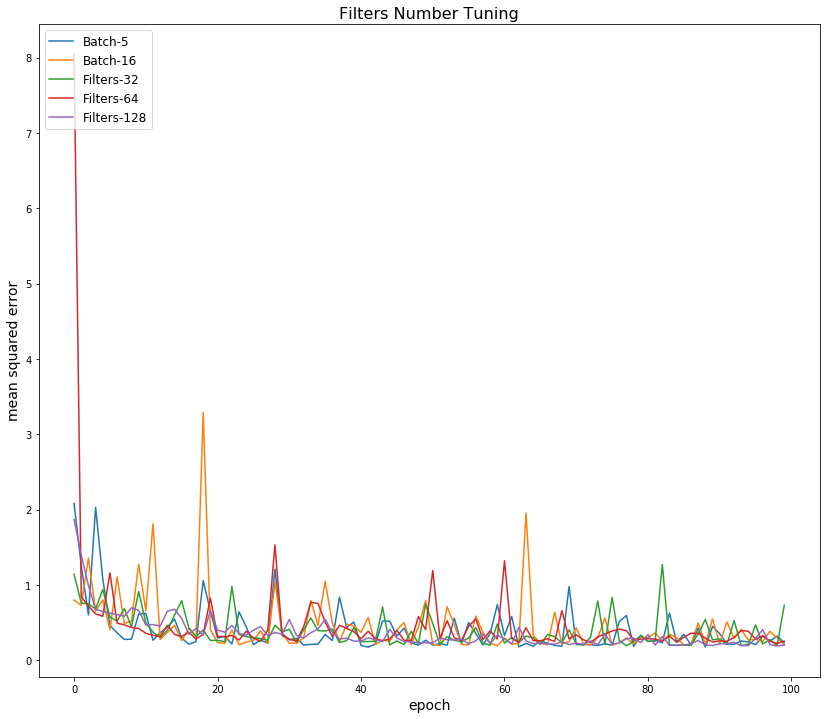

In [196]:
#Tune batch size
results=[]
for i in [5,16,32,64,128]:
    testModel = Sequential()
    testModel.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation='relu'), input_shape=(None, 10, 1)))
    testModel.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    testModel.add(TimeDistributed(Flatten()))
    testModel.add(LSTM(100, activation='relu'))
    testModel.add(Dense(1,activation='linear'))
    testModel.compile(optimizer='adam', loss='mse')
    history=testModel.fit(x_train,y_train,batch_size=i,epochs=100,validation_split=0.2,verbose=0,use_multiprocessing=True)
    results.append(history.history['val_loss'])

plt.figure(figsize=(14,12))
for i in range(0,len(results)):
    plt.plot(np.arange(100),results[i])
plt.title('Filters Number Tuning',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['Batch-5','Batch-16','Filters-32','Filters-64','Filters-128'], loc='upper left', fontsize='large')
plt.show()

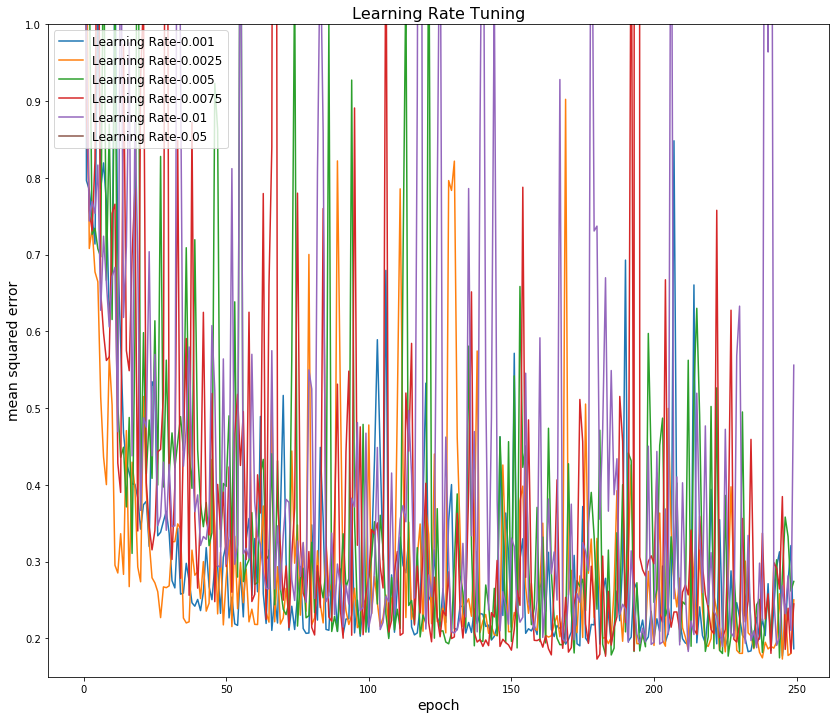

In [19]:
#Tune learning rate
results=[]
for i in [0.001,0.0025,0.005,0.0075,0.01,0.05]:
    testModel = Sequential()
    testModel.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation='relu'), input_shape=(None, 10, 1)))
    testModel.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    testModel.add(TimeDistributed(Flatten()))
    testModel.add(LSTM(100, activation='relu'))
    testModel.add(Dense(1,activation='linear'))
    testModel.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=i,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam"
    ), loss='mse')
    history=testModel.fit(x_train,y_train,batch_size=128,epochs=250,validation_split=0.2,verbose=0,use_multiprocessing=True)
    results.append(history.history['val_loss'])

plt.figure(figsize=(14,12))
for i in range(0,len(results)):
    plt.plot(np.arange(250),results[i])
plt.title('Learning Rate Tuning',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['Learning Rate-0.001','Learning Rate-0.0025','Learning Rate-0.005','Learning Rate-0.0075',
            'Learning Rate-0.01','Learning Rate-0.05'], loc='upper left', fontsize='large')
plt.ylim(0.15,1)
plt.show()

In [25]:
#Tune for kernel initialization
testModel=Sequential()
testModel.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation='relu'), input_shape=(None, 10, 1)))
testModel.add(TimeDistributed(MaxPooling1D(pool_size=2)))
testModel.add(TimeDistributed(Flatten()))
testModel.add(LSTM(100, activation='relu'))
testModel.add(Dense(1,activation='linear'))
testModel.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0075,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam"
), loss='mse')
history1=testModel.fit(x_train,y_train,batch_size=128,epochs=200,validation_split=0.2,verbose=0,use_multiprocessing=True)

testModel = Sequential()
testModel.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=2/np.sqrt(1024)), input_shape=(None, 10, 1))))
testModel.add(TimeDistributed(MaxPooling1D(pool_size=2)))
testModel.add(TimeDistributed(Flatten()))
testModel.add(LSTM(100, activation='relu'))
testModel.add(Dense(1,activation='linear'))
testModel.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0075,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam"
), loss='mse')
history2=testModel.fit(x_train,y_train,batch_size=128,epochs=200,validation_split=0.2,verbose=0,use_multiprocessing=True)

testModel=Sequential()
testModel.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal()), input_shape=(None, 10, 1)))
testModel.add(TimeDistributed(MaxPooling1D(pool_size=2)))
testModel.add(TimeDistributed(Flatten()))
testModel.add(LSTM(100, activation='relu'))
testModel.add(Dense(1,activation='linear'))
testModel.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0075,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam"
), loss='mse')
history3=testModel.fit(x_train,y_train,batch_size=128,epochs=200,validation_split=0.2,verbose=0,use_multiprocessing=True)

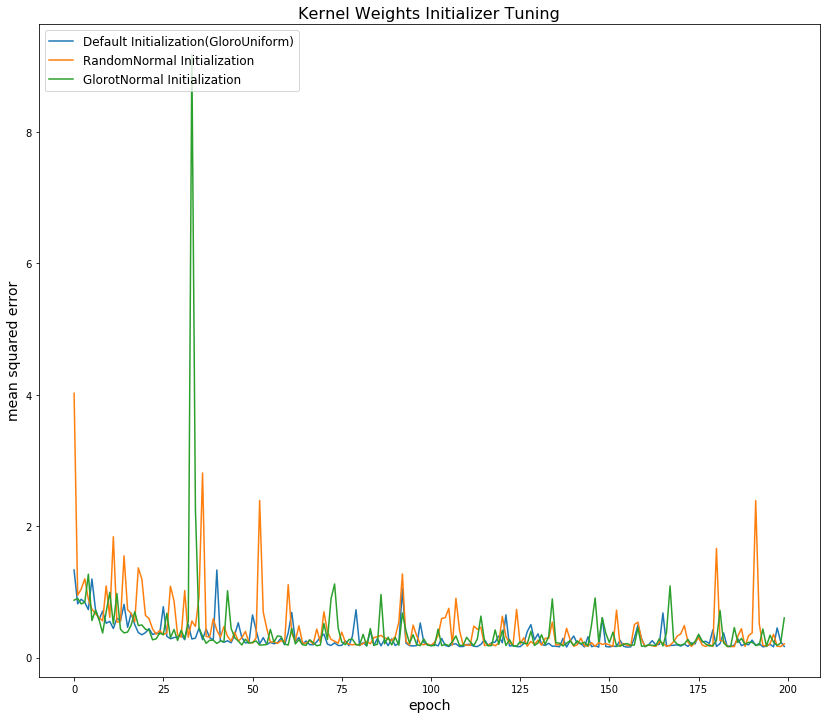

In [26]:
plt.figure(figsize=(14,12))
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.title('Kernel Weights Initializer Tuning',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['Default Initialization(GloroUniform)','RandomNormal Initialization','GlorotNormal Initialization'], loc='upper left', fontsize='large')
plt.show()

Train Model

In [84]:
model.fit(x_train,y_train,batch_size=128,epochs=270,validation_split=0.2,callbacks=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=75,
    restore_best_weights=True,
))

Epoch 1/270
25/25 [==============================] - 0s 6ms/step - loss: 0.0209 - val_loss: 0.1975
Epoch 2/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0211 - val_loss: 0.1995
Epoch 3/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0215 - val_loss: 0.2232
Epoch 4/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0218 - val_loss: 0.2229
Epoch 5/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0214 - val_loss: 0.2235
Epoch 6/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0225 - val_loss: 0.2392
Epoch 7/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0223 - val_loss: 0.2055
Epoch 8/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0213 - val_loss: 0.1958
Epoch 9/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.1946
Epoch 10/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.2005
Epoch 11/

25/25 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.1782
Epoch 84/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0190 - val_loss: 0.1859
Epoch 85/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0193 - val_loss: 0.1793
Epoch 86/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0250 - val_loss: 0.3462
Epoch 87/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0205 - val_loss: 0.2120
Epoch 88/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0217 - val_loss: 0.1865
Epoch 89/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0205 - val_loss: 0.1805
Epoch 90/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0189 - val_loss: 0.2554
Epoch 91/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0194 - val_loss: 0.1783
Epoch 92/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0213 - val_loss: 0.2569
Epoch 93/270


25/25 [==============================] - 0s 4ms/step - loss: 0.0209 - val_loss: 0.1915
Epoch 165/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0190 - val_loss: 0.1908
Epoch 166/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0248 - val_loss: 0.1770
Epoch 167/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0231 - val_loss: 0.2039
Epoch 168/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.1709
Epoch 169/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0179 - val_loss: 0.2001
Epoch 170/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0264 - val_loss: 0.6015
Epoch 171/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0345 - val_loss: 0.5155
Epoch 172/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0278 - val_loss: 0.1809
Epoch 173/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0180 - val_loss: 0.1894
Epoc

25/25 [==============================] - 0s 4ms/step - loss: 0.0175 - val_loss: 0.1686
Epoch 246/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0172 - val_loss: 0.1674
Epoch 247/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0170 - val_loss: 0.1734
Epoch 248/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.1857
Epoch 249/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0191 - val_loss: 0.1887
Epoch 250/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0232 - val_loss: 0.1742
Epoch 251/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.1660
Epoch 252/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.1721
Epoch 253/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0202 - val_loss: 0.2763
Epoch 254/270
25/25 [==============================] - 0s 4ms/step - loss: 0.0199 - val_loss: 0.2403
Epoc

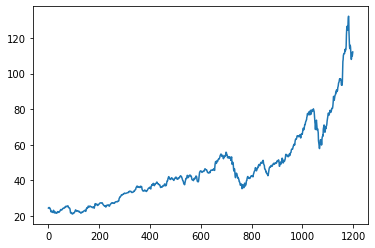

In [79]:
predicted=model.predict(x_test)
plt.plot(predicted.flatten())

In [80]:
from sklearn.metrics import mean_squared_error
print('MSE of the CNN-LSTM Hybrid Model is: ',mean_squared_error(predicted,y_test))

MSE of the CNN-LSTM Hybrid Model is:  1.9063140002366783


In [81]:
model.save('CNN+LSTM_MSE1.90')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: CNN+LSTM_MSE1.90/assets


In [82]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis (None, None, 6, 32)       192       
_________________________________________________________________
time_distributed_37 (TimeDis (None, None, 3, 32)       0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, None, 96)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               78800     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 79,093
Trainable params: 79,093
Non-trainable params: 0
_________________________________________________________________


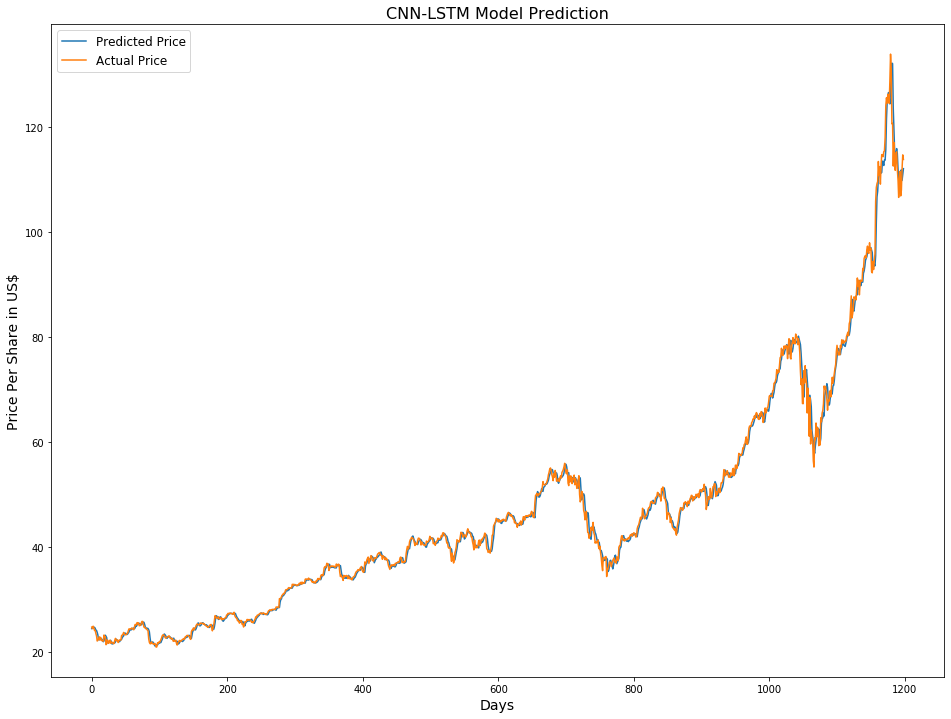

In [83]:
fig=plt.figure(figsize=(16,12))
plt.xlabel('Days',fontsize='14')
plt.ylabel('Price Per Share in US$',fontsize='14')
plt.title('CNN-LSTM Model Prediction',fontsize='16')
pred, = plt.plot([i for i in range(len(hist[4000:])-training_window)], predicted.flatten())
actual, = plt.plot([i for i in range(len(hist[4000+training_window:]))], hist[4000+training_window:])
plt.legend([pred, actual], ['Predicted Price', 'Actual Price'], loc='upper left', fontsize='large')
plt.savefig('a.svg')
plt.show()

# Multi-variate LSTM

Data Preprocessing

In [3]:
hist=hist.reset_index()
hist=hist.loc[:,'Close']
hist=pd.DataFrame(hist)

Data Transformation

In [4]:
hist['SMA_10']=hist['Close'].rolling(10).mean().shift()
#hist['SMA_20']=hist['Close'].rolling(20).mean().shift()

multiplier10=2 / (10 + 1)
#multiplier20=2 / (20 + 1)
hist['EMA_10']=np.nan
#hist['EMA_20']=np.nan
hist.loc[10,'EMA_10']=hist.loc[10,'SMA_10']
#hist.loc[20,'EMA_20']=hist.loc[20,'SMA_20']

for i in range(11,hist.shape[0]):
    hist.loc[i,'EMA_10']=(hist.loc[i,'Close']*multiplier10)+(hist.loc[i-1,'EMA_10']*(1-multiplier10))
#     if i >20:
#         hist.loc[i,'EMA_20']=(hist.loc[i,'Close']*multiplier20)+(hist.loc[i-1,'EMA_20']*(1-multiplier20))

hist['STD_10']=hist['Close'].rolling(10).std().shift()
#hist['STD_20']=hist['Close'].rolling(20).std().shift()

hist['BB_Bandwidth10']=2*1.5*hist['STD_10']

hist=hist.dropna(axis=0)

hist=hist.drop(columns=['SMA_10','STD_10']).reset_index()

hist=hist.drop(columns=['index'])

Feature Scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler
columns=hist.columns
scaler=MinMaxScaler()
train=scaler.fit_transform(hist.iloc[:4000,:])
train=pd.DataFrame(train,columns=columns)
test=scaler.transform(hist.iloc[4000:,:])
test=pd.DataFrame(test,columns=columns)

Data Transformation

In [6]:
close_train=hist['Close'].tolist()[:4000]
close_test=hist['Close'].tolist()[4000:]
training_window=20
forward_window=1
x=[]
y=[]
counter=0
for i in range(0,train.shape[0]-forward_window-training_window+1,forward_window):
    x.append(np.array(train.iloc[i:(i+training_window),:]))
    y.append(np.array(close_train[(i+training_window):(i+training_window+forward_window)]))
x_train=np.array(x)
y_train=np.array(y)
x=[]
y=[]
for i in range(0,test.shape[0]-forward_window-training_window+1,forward_window):
    x.append(np.array(test.iloc[i:(i+training_window),:]))
    y.append(np.array(close_test[(i+training_window):(i+training_window+forward_window)]))
x_test=np.array(x)
y_test=np.array(y)

Initializing the model

In [7]:
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout,Activation
import tensorflow as tf
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import BatchNormalization

model=Sequential()
model.add(LSTM(300,activation='relu',return_sequences=True,input_shape=(training_window,3),kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=2/np.sqrt(1024), seed=None)))
model.add(BatchNormalization())
model.add(LSTM(150,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.005,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam"
    ))

Model Tuning

In [ ]:
#Tune model complexity
results=[]
for i in [200,250,300,350,400,450]:
    testModel=Sequential()
    testModel.add(LSTM(i,activation='relu',return_sequences=True,input_shape=(training_window,3),kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=2/np.sqrt(1024), seed=None)))
    testModel.add(BatchNormalization())
    testModel.add(LSTM(int(i/2),activation='relu'))
    testModel.add(Dense(1,activation='linear'))
    testModel.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.005,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam"
    ))
    history=testModel.fit(x_train,y_train,batch_size=512,epochs=10,validation_split=0.2,verbose=0,use_multiprocessing=True)
    results.append(history.history['val_loss'])

In [25]:
#Tune batch size
results=[]
for i in [16,32,64,128]:
    testModel=Sequential()
    testModel.add(LSTM(100,activation='relu',return_sequences=True,input_shape=(training_window,3),kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=2/np.sqrt(1024), seed=None)))
    testModel.add(BatchNormalization())
    testModel.add(LSTM(50,activation='relu'))
    testModel.add(Dense(1,activation='linear'))
    testModel.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.005,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam"
    ))
    history=testModel.fit(x_train,y_train,batch_size=i,epochs=200,validation_split=0.2,verbose=0,use_multiprocessing=True)
    results.append(history.history['val_loss'])
    print(i)

plt.figure(figsize=(14,12))
for i in range(1,len(results)):
    plt.plot(np.arange(300),results[i])
plt.title('Batch Size Tuning',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['BatchSize-16','BatchSize-32','BatchSize-64','BatchSize-128'], loc='upper left', fontsize='large')
plt.ylim(0,1.5)
plt.show()

KeyboardInterrupt: 

Train the model

In [8]:
model.fit(x_train,y_train,batch_size=128,epochs=200,validation_split=0.2,callbacks=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=60,
    restore_best_weights=True,
))

Epoch 1/200
25/25 [==============================] - 2s 96ms/step - loss: 44.9378 - val_loss: 343.2210
Epoch 2/200
25/25 [==============================] - 2s 86ms/step - loss: 0.8812 - val_loss: 347.2038
Epoch 3/200
25/25 [==============================] - 2s 94ms/step - loss: 0.3781 - val_loss: 345.2561
Epoch 4/200
25/25 [==============================] - 2s 88ms/step - loss: 0.3754 - val_loss: 350.4224
Epoch 5/200
25/25 [==============================] - 2s 89ms/step - loss: 0.3047 - val_loss: 333.3634
Epoch 6/200
25/25 [==============================] - 2s 93ms/step - loss: 0.5323 - val_loss: 344.7432
Epoch 7/200
25/25 [==============================] - 2s 94ms/step - loss: 0.4183 - val_loss: 348.8393
Epoch 8/200
25/25 [==============================] - 2s 90ms/step - loss: 1.0666 - val_loss: 312.2716
Epoch 9/200
25/25 [==============================] - 2s 90ms/step - loss: 0.3252 - val_loss: 319.9842
Epoch 10/200
25/25 [==============================] - 2s 94ms/step - loss: 0.3280

25/25 [==============================] - 2s 94ms/step - loss: 0.0850 - val_loss: 2.7745
Epoch 82/200
25/25 [==============================] - 2s 94ms/step - loss: 0.0679 - val_loss: 2.1446
Epoch 83/200
25/25 [==============================] - 2s 93ms/step - loss: 0.0721 - val_loss: 4.1756
Epoch 84/200
25/25 [==============================] - 2s 94ms/step - loss: 0.0592 - val_loss: 1.5080
Epoch 85/200
25/25 [==============================] - 2s 94ms/step - loss: 0.0890 - val_loss: 2.6024
Epoch 86/200
25/25 [==============================] - 2s 96ms/step - loss: 0.0571 - val_loss: 1.6878
Epoch 87/200
25/25 [==============================] - 2s 94ms/step - loss: 0.0565 - val_loss: 1.9168
Epoch 88/200
25/25 [==============================] - 2s 94ms/step - loss: 0.1210 - val_loss: 3.0882
Epoch 89/200
25/25 [==============================] - 3s 100ms/step - loss: 0.0668 - val_loss: 2.3722
Epoch 90/200
25/25 [==============================] - 2s 100ms/step - loss: 0.0764 - val_loss: 1.6876
E

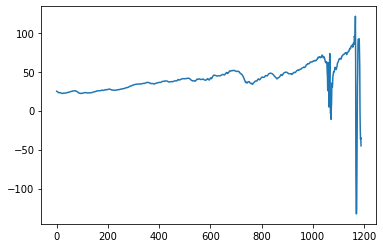

In [9]:
predicted=model.predict(x_test)
plt.plot(predicted)

In [10]:
from sklearn.metrics import mean_squared_error
print('MSE of the Multivariate LSTM is:',mean_squared_error(predicted,y_test))

MSE of the Multivariate LSTM is: 430.3885359706769
